# Training loop draft 3 - Multiclass
J. Cristiano

This is the training loop thats gonna have all the moving parts in it:     
- Data Augmentation 
- Weighted Cross entropy loss
- Transfer learning

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
from PIL import Image, ImageDraw
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Loading and combining datasets
Also using a custom padding function to make the images square

The code below is a custom padding transform that I found on a [github feature request](https://github.com/pytorch/vision/issues/8699) to torvision transforms v2. The code looked good to the reviewers and was [pushed to a PR](https://github.com/pytorch/vision/pull/8701), but the writer of the code promptly closed the PR due to the threat of spurious correlations that can be created by the padding. For example: in a classification dataset if all airplanes are in landscape, then the letterbox padding could "reinforce that bias"  

In [2]:
from typing import Any, Dict, List, Literal, Union, Type

import torchvision.transforms.v2.functional as F
from torchvision.transforms import v2
from torchvision.transforms.v2._utils import (
    _check_padding_mode_arg,
    _get_fill,
    _setup_fill_arg,
    _FillType,
)


class PadSquare(v2.Transform):
    """Pad a non-square input to make it square by padding the shorter side to match the longer side.
    Args:
        fill (number or tuple or dict, optional): Pixel fill value used when the  ``padding_mode`` is constant.
            Default is 0. If a tuple of length 3, it is used to fill R, G, B channels respectively.
            Fill value can be also a dictionary mapping data type to the fill value, e.g.
            ``fill={tv_tensors.Image: 127, tv_tensors.Mask: 0}`` where ``Image`` will be filled with 127 and
            ``Mask`` will be filled with 0.
        padding_mode (str, optional): Type of padding. Should be: constant, edge, reflect or symmetric.
            Default is "constant".

            - constant: pads with a constant value, this value is specified with fill

            - edge: pads with the last value at the edge of the image.

            - reflect: pads with reflection of image without repeating the last value on the edge.
              For example, padding [1, 2, 3, 4] with 2 elements on both sides in reflect mode
              will result in [3, 2, 1, 2, 3, 4, 3, 2]

            - symmetric: pads with reflection of image repeating the last value on the edge.
              For example, padding [1, 2, 3, 4] with 2 elements on both sides in symmetric mode
              will result in [2, 1, 1, 2, 3, 4, 4, 3]

    Example:
        >>> import torch
        >>> from torchvision.transforms.v2 import PadSquare
        >>> rectangular_image = torch.randint(0, 255, (3, 224, 168), dtype=torch.uint8)
        >>> transform = PadSquare(padding_mode='constant', fill=0)
        >>> square_image = transform(rectangular_image)
        >>> print(square_image.size())
        torch.Size([3, 224, 224])
    """

    def __init__(
        self,
        fill: Union[_FillType, Dict[Union[Type, str], _FillType]] = 0,
        padding_mode: Literal["constant", "edge", "reflect", "symmetric"] = "constant",
    ):
        super().__init__()

        _check_padding_mode_arg(padding_mode)

        if padding_mode not in ["constant", "edge", "reflect", "symmetric"]:
            raise ValueError(
                "`padding_mode` must be one of 'constant', 'edge', 'reflect' or 'symmetric'."
            )
        self.padding_mode = padding_mode
        self.fill = _setup_fill_arg(fill)

    def _get_params(self, flat_inputs: List[Any]) -> Dict[str, Any]:
        # Get the original height and width from the inputs
        orig_height, orig_width = v2.query_size(flat_inputs)

        # Find the target size (maximum of height and width)
        target_size = max(orig_height, orig_width)

        if orig_height < target_size:
            # Need to pad height
            pad_height = target_size - orig_height
            pad_top = pad_height // 2
            pad_bottom = pad_height - pad_top
            pad_left = 0
            pad_right = 0
        else:
            # Need to pad width
            pad_width = target_size - orig_width
            pad_left = pad_width // 2
            pad_right = pad_width - pad_left
            pad_top = 0
            pad_bottom = 0

        # The padding needs to be in the format [left, top, right, bottom]
        return dict(padding=[pad_left, pad_top, pad_right, pad_bottom])

    def _transform(self, inpt: Any, params: Dict[str, Any]) -> Any:
        fill = _get_fill(self.fill, type(inpt))
        return self._call_kernel(
            F.pad,
            inpt,
            padding=params["padding"],
            padding_mode=self.padding_mode,
            fill=fill
        )

In [3]:
coco_roots = ['/work/2021_annot/images',
              '/work/2022_annot/images',
              '/work/2023_annot/images',
              '/work/2024_annot/images']

coco_annFiles = ['/work/2021_annot/2021_annotations.json',
                 '/work/2022_annot/2022_annotations.json',
                 '/work/2023_annot/2023_annotations.json',
                 '/work/2024_annot/2024_annotations.json']
standard_transform = transforms.v2.Compose([
    PadSquare(padding_mode='symmetric'),
    v2.Resize((512, 512)), 
    v2.ToImage()
    ])
full_dataset = datasets.CocoDetection(root=coco_roots[0], annFile=coco_annFiles[0], transforms=standard_transform)
full_dataset = datasets.wrap_dataset_for_transforms_v2(full_dataset, target_keys=("labels", "masks"))
for coco_root, coco_annFile in zip(coco_roots[1:], coco_annFiles[1:]):
    seasonal_dataset = datasets.CocoDetection(root=coco_root, annFile=coco_annFile, transforms=standard_transform)
    seasonal_dataset = datasets.wrap_dataset_for_transforms_v2(seasonal_dataset, target_keys=("labels", "masks"))
    full_dataset = torch.utils.data.ConcatDataset([full_dataset, seasonal_dataset])

train_size = int(0.8 * len(full_dataset))
test_size = int(0.2 * len(full_dataset))
test_size += len(full_dataset) - (train_size + test_size)
full_dataset.train, full_dataset.test = torch.utils.data.random_split(full_dataset, [train_size, test_size])

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


# Data Augmentations & Dataloaders 

In [4]:
augmentations = transforms.v2.Compose([
    transforms.v2.RandomPerspective(distortion_scale=0.25, p=0.5),
    transforms.v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.v2.RandomHorizontalFlip(p=0.5),
    transforms.v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.v2.RandomRotation(degrees=5)
])

def custom_collate_fn(batch):
    # Unpack the batch - assuming each item is a (image, mask) tuple
    images, masks = zip(*batch)
    mask_batch = []
    for mask in masks:
        multiclass_mask = torch.zeros((4, mask["masks"].shape[1], mask["masks"].shape[2]), dtype=mask["masks"].dtype)
        for idx, label in enumerate(mask["labels"]):
            multiclass_mask[label] = mask["masks"][idx]
        multiclass_mask[0] = 1 - torch.max(multiclass_mask[1:], dim=0)[0]
        mask_batch.append(multiclass_mask)

    return images, mask_batch

full_dataset.train.transforms = transforms.v2.Compose([standard_transform, augmentations])
full_dataset.test.transforms = standard_transform
train_dataloader = DataLoader(
    full_dataset.train, 
    batch_size=8, 
    shuffle=True, 
    num_workers=2,
    collate_fn=custom_collate_fn)
test_dataloader = DataLoader(
    full_dataset.test, 
    batch_size=8, 
    shuffle=True, 
    num_workers=2,
    collate_fn=custom_collate_fn)

# Calculating class imbalances for weighted cross entropy loss

In [5]:
# Calculate class weights for weighted cross entropy
class_counts = torch.zeros(4)
total_pixels = 0
print("Calculating class imbalances")
for _, masks in tqdm(train_dataloader):
    for mask in masks:
        for i in range(4):
            class_counts[i] += mask[i].sum()
        total_pixels += mask[0].numel()
class_weights = 1.0 / (class_counts + 1e-8)  # add small epsilon to avoid division by zero
class_weights = class_weights / class_weights.sum() * len(class_weights)  # normalize weights
print(f"Class weights: {class_weights}")

Calculating class imbalances


100%|█████████████████████████████████████████████| 42/42 [01:02<00:00,  1.48s/it]

Class weights: tensor([0.0203, 1.4344, 1.8239, 0.7213])


# training loop

In [6]:
#training loop 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torch.nn as nn


preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)
model.to(device)
criterion = nn.CrossEntropyLoss(class_weights.to(device))

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
training_results = {
    "train_loss": [],
    "test_loss" : [], 
    "test_accuracy": [],
    "pocket_loss": None,
    "pocket_model": None,
}
for epoch in tqdm(range(50)):
    running_loss = 0.0
    for img, mask in train_dataloader:
        model.train()
        img = torch.stack([torch.tensor(preprocess_input(i.permute(1, 2, 0).numpy())) for i in img])
        img = img.permute(0, 3, 1, 2).float()
        result = model(img.to(device))
        mask = torch.stack(mask)
        loss = criterion(result.to(device), mask.float().to(device))
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    training_results["train_loss"].append(running_loss/len(train_dataloader))
    running_loss = 0.0
    running_accuracy = 0.0
    for img, mask in test_dataloader:
        model.eval()
        img = torch.stack([torch.tensor(preprocess_input(i.permute(1, 2, 0).numpy())) for i in img])
        img = img.permute(0, 3, 1, 2).float()
        result = model(img.to(device))
        mask = torch.stack(mask)
        loss = criterion(result.to(device), mask.float().to(device))
        correct = (result.to(device) == mask.float().to(device)).sum().item()
        running_accuracy += ( correct / mask.numel() )
        running_loss += loss.item()
    training_results["test_loss"].append(running_loss/len(test_dataloader))    
    training_results["test_accuracy"].append(running_accuracy/len(test_dataloader))
    
    if training_results["pocket_loss"] == None or  training_results["test_loss"][-1] < training_results["pocket_loss"]:
            training_results["pocket_loss"] = loss.item()
            training_results["pocket_model"] = model.state_dict().copy()
    # print(f"Epoch {epoch} - Loss: {training_results['train_loss'][-1]}")
    # print(f"Epoch {epoch} - Test Loss: {training_results['test_loss'][-1]}") 



# plot([img, combined_mask])
# plot(result.squeeze().detach().cpu().numpy())


100%|███████████████████████████████████████████| 50/50 [1:07:41<00:00, 81.23s/it]


In [ ]:
from torch.utils.tensorboard import SummaryWriter
x = torch.randn(1, 1, 512, 512)
# Create a SummaryWriter object to log the information
writer = SummaryWriter("logs")

# Log the model graph to the writer
writer.add_graph(model, x)

# Close the writer
writer.close()


# Plotting the results

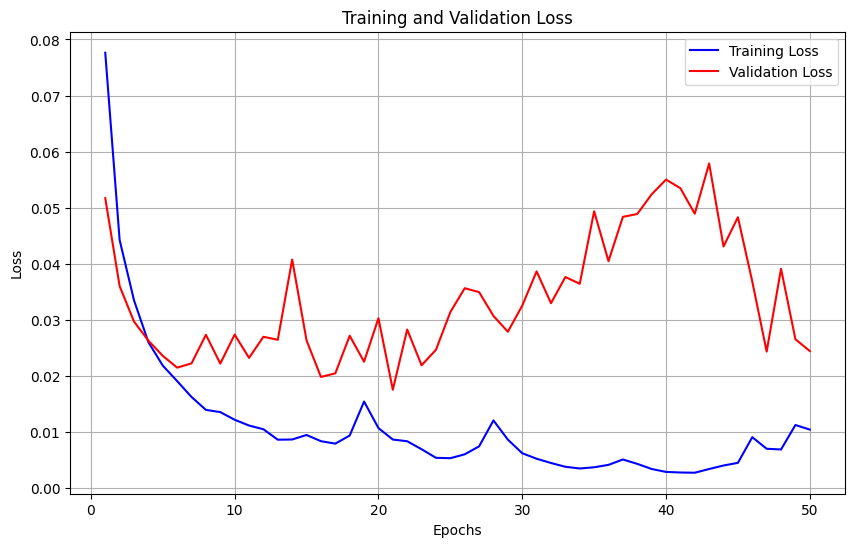

In [7]:
def plot_training_history(train_loss, test_loss, save_path=None):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_loss) + 1)
    
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, test_loss, 'r-', label='Validation Loss')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()
plot_training_history(training_results["train_loss"], training_results["test_loss"])

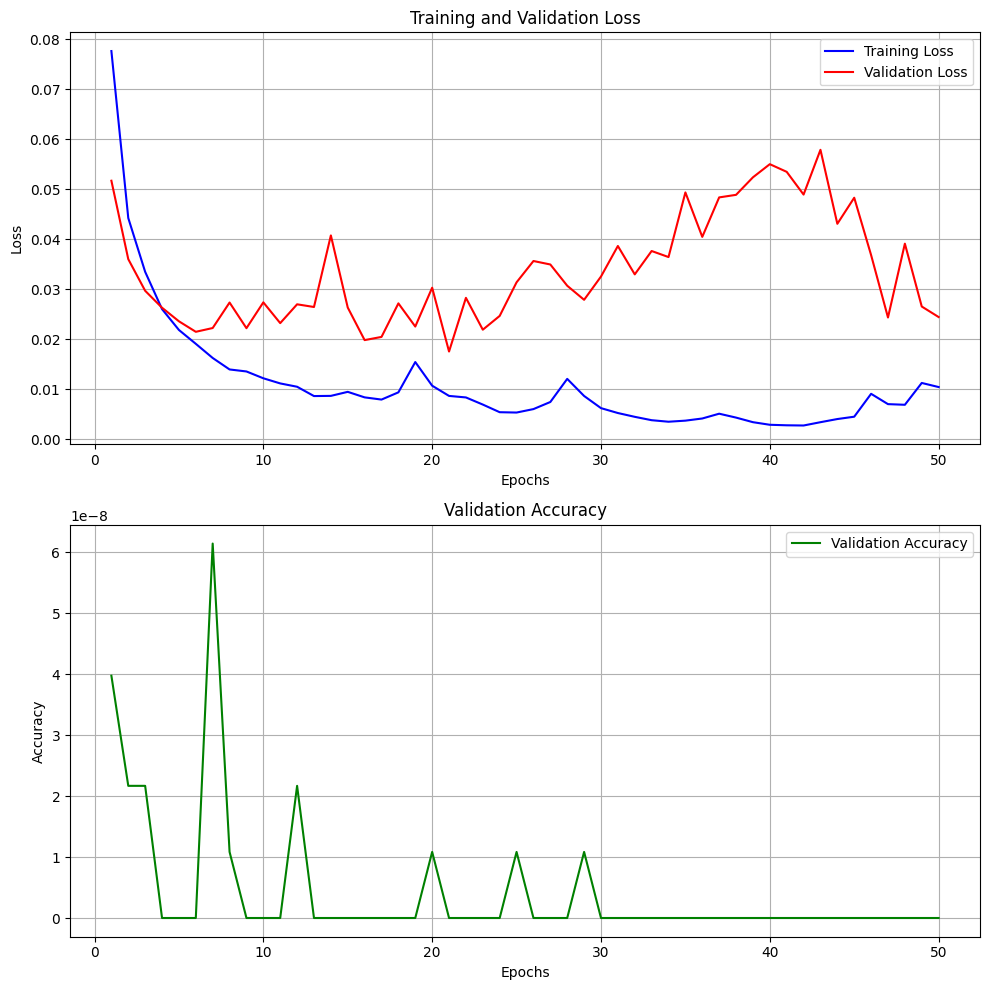

In [8]:
def plot_training_history(train_loss, test_loss, test_accuracy, save_path=None):
    # Create figure with 2 subplots stacked vertically
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    epochs = range(1, len(train_loss) + 1)
    
    # Plot losses on first subplot
    ax1.plot(epochs, train_loss, 'b-', label='Training Loss')
    ax1.plot(epochs, test_loss, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.legend()
    
    # Plot accuracy on second subplot
    ax2.plot(epochs, test_accuracy, 'g-', label='Validation Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    ax2.legend()
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Call the function with the additional accuracy parameter
plot_training_history(
    training_results["train_loss"], 
    training_results["test_loss"],
    training_results["test_accuracy"]
)

In [9]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.datasets.coco import CocoDetection

def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

length of test dataset: 83


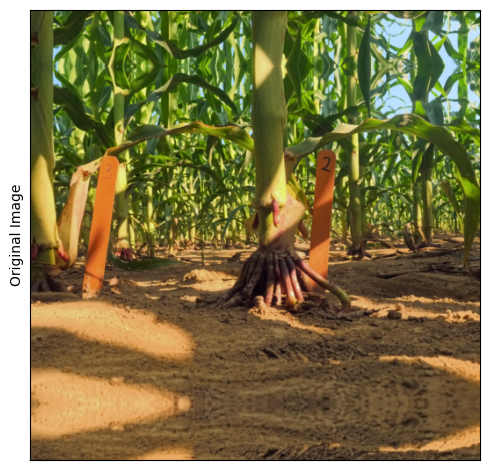

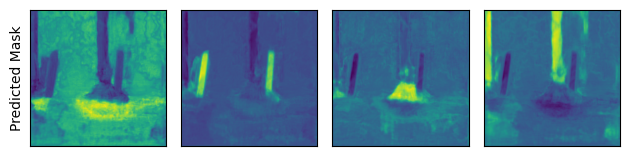

In [14]:
print(f"length of test dataset: {len(full_dataset.test)}")
image, target = full_dataset.test[12]
image = torch.tensor(preprocess_input(image.permute(1, 2, 0).numpy()))
image = image.permute(2, 0, 1).unsqueeze(0).float()
result = model(image.to(device))
plot(image, row_title=["Original Image"])
plot(result.squeeze().detach().cpu().numpy(), row_title=["Predicted Mask"])

In [11]:
torch.save(training_results["pocket_model"], '/work/multiclass_multiyear_UNET_sm.pth')